# University Project for "Data Science and Machine Learning" Course 

## What dataset did we chose?

We choose the following dataset: [TLC Trip Record Data: Yellow Taxi Trip Records in 2024](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)


## What is our prediction target?

Prediction of tip amount

## What features do we include?

In order to predict the tip amount, we selected the following features from the dataset based on their relevance to the tipping behavior. These features may influence how much a passenger tips, depending on trip characteristics, fare, or contextual factors:

| Feature                       | Description                                                     | Reason for Inclusion                                                                                                     |
| ----------------------------- | --------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ |
| `tpep_pickup_datetime`        | Timestamp of trip start                                         | Helps extract temporal features like hour, day of week, seasonality which can affect tipping patterns.                   |
| `tpep_dropoff_datetime`       | Timestamp of trip end                                           | Enables calculation of trip duration and alignment with weather data.                                                    |
| `passenger_count`             | Number of passengers                                            | Tipping may vary based on group size; missing or zero values will be removed.                                            |
| `trip_distance`               | Distance of the trip in miles                                   | Longer trips may correlate with higher tips.                                                                             |
| `PULocationID`                | Pickup location ID (TLC Zone)                                   | Pickup zones may differ in customer profiles or tipping habits.                                                          |
| `DOLocationID`                | Drop-off location ID                                            | Same reasoning as pickup location.                                                                                       |
| `payment_type`                | Payment method (e.g., cash, card)                               | Tip is only recorded for card payments; strongly correlates with target.                                                 |
| `tip_amount`                 | Metered fare for the trip                                       | Base fare may influence tip amount.                                                                                      |
| `extra`                       | Surcharges and extras (e.g., night fee)                         | Affects total fare and possibly tipping.                                                                                 |
| `tolls_amount`                | Total tolls paid during trip                                    | Increases total cost and may impact tipping behavior.                                                                    |
| `total_amount`                | Total amount paid (excluding cash tips)                         | Contextual info, possibly redundant but still useful.                                                                    |
| `airport_fee`                 | Only applies to airport trips                                   | Might represent a special trip category with different tipping habits.                                                   |
| `weather` *(external source)* | Historical weather data from [Meteostat](https://meteostat.net) | Weather (e.g., temperature, rain) may affect trip length, mood, and tipping behavior. Will be merged based on date/time. |

These features were selected based on their direct or indirect relationship to the customer's experience, fare cost, and context of the ride. Features like `VendorID`, `RatecodeID`, `mta_tax`, and `store_and_fwd_flag` were excluded due to missing values or low relevance.

## 1. Data Understanding & 2. Business Understanding

Official explanation from TLC:
```txt
Trips made by New York City’s iconic yellow taxis have been recorded and provided to the TLC since 2009. Yellow taxis are traditionally hailed by signaling to a driver who is on duty and seeking a passenger (street hail), but now they may also be hailed using an e-hail app like Curb or Arro. Yellow taxis are the only vehicles permitted to respond to a street hail from a passenger in all five boroughs. Records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The records were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology service providers. The trip data was not created by the TLC, and TLC cannot guarantee their accuracy.
```

We downloaded 12 [`PARQUET`](https://parquet.apache.org/) files from the [TLC website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Each file represents one month of yellow taxi trips records in 2024. `PARQUET` is a columnar storage format, which means data is organized by columns rather than rows, allowing for more efficient querying and compression compared to row-based formats like `CSV`.

Overview of the files:
|File|Columns|Rows|Size|
|-|-|-|-|
|yellow_tripdata_2024-01.parquet|19|2.964.624|47.65 MB|
|yellow_tripdata_2024-02.parquet|19|3.007.526|48.02 MB|
|yellow_tripdata_2024-03.parquet|19|3.582.628|57.30 MB|
|yellow_tripdata_2024-04.parquet|19|3.514.289|56.39 MB|
|yellow_tripdata_2024-05.parquet|19|3.723.833|59.66 MB|
|yellow_tripdata_2024-06.parquet|19|3.539.193|57.09 MB|
|yellow_tripdata_2024-07.parquet|19|3.076.903|49.88 MB|
|yellow_tripdata_2024-08.parquet|19|2.979.183|48.70 MB|
|yellow_tripdata_2024-09.parquet|19|3.633.030|58.34 MB|
|yellow_tripdata_2024-10.parquet|19|3.833.771|61.37 MB|
|yellow_tripdata_2024-11.parquet|19|3.646.369|57.85 MB|
|yellow_tripdata_2024-12.parquet|19|3.668.371|58.67 MB|

In [1]:
# Get information about parquet files
import os
import datetime as dt
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily
import holidays as hd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

months = [f"{i:02d}" for i in range(1, 13)]

for month in months:
    file_path = f"data/yellow_tripdata_2024-{month}.parquet"
    try:
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        df = pd.read_parquet(file_path)
        print(f"File: {file_path}")
        print(f"Size: {size_mb:.2f} MB")
        print(f"Columns: {df.columns.tolist()}")
        print(f"Number of rows: {len(df)}")
        print("-" * 50)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

File: data/yellow_tripdata_2024-01.parquet
Size: 47.65 MB
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
Number of rows: 2964624
--------------------------------------------------
File: data/yellow_tripdata_2024-02.parquet
Size: 48.02 MB
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
Number of rows: 3007526
--------------------------------------------------
File: data/yellow_tripdata_2024-03.parquet
Size: 57.30 MB
Colu

In [2]:
january_df = pd.read_parquet("data/yellow_tripdata_2024-01.parquet")
display(january_df.head())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


5 example rows:
```markdown
	VendorID	tpep_pickup_datetime	tpep_dropoff_datetime	passenger_count	trip_distance	RatecodeID	store_and_fwd_flag	PULocationID	DOLocationID	payment_type	fare_amount	extra	mta_tax	tip_amount	tolls_amount	improvement_surcharge	total_amount	congestion_surcharge	Airport_fee
0	2	2024-01-01 00:57:55	2024-01-01 01:17:43	1.0	1.72	1.0	N	186	79	2	17.7	1.0	0.5	0.00	0.0	1.0	22.70	2.5	0.0
1	1	2024-01-01 00:03:00	2024-01-01 00:09:36	1.0	1.80	1.0	N	140	236	1	10.0	3.5	0.5	3.75	0.0	1.0	18.75	2.5	0.0
2	1	2024-01-01 00:17:06	2024-01-01 00:35:01	1.0	4.70	1.0	N	236	79	1	23.3	3.5	0.5	3.00	0.0	1.0	31.30	2.5	0.0
3	1	2024-01-01 00:36:38	2024-01-01 00:44:56	1.0	1.40	1.0	N	79	211	1	10.0	3.5	0.5	2.00	0.0	1.0	17.00	2.5	0.0
4	1	2024-01-01 00:46:51	2024-01-01 00:52:57	1.0	0.80	1.0	N	211	148	1	7.9	3.5	0.5	3.20	0.0	1.0	16.10	2.5	0.0
```

Overview of the columns:
|#|Field name|Description|Datatype|Include (y/n)|
|-|-|-|-|-|
|1|VendorID|A code indicating the TPEP provider that provided the record|1, 2, 6, 7|n|
|2|tpep_pickup_datetime|The date and time when the meter was engaged|2024-01-01 00:57:55|y|
|3|tpep_dropoff_datetime|The date and time when the meter was disengaged|2024-01-01 00:57:55|y|
|4|passenger_count|The number of passengers in the vehicle|1, 2, ...|y|
|5|trip_distance|The elapsed trip distance in miles reported by the taximeter|0.0, 1.78, 23.9|y|
|6|RatecodeID|The final rate code in effect at the end of the trip|1, 2, 3, 4, 5, 6, 99|n|
|7|store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka "store and forward," because the vehicle did not have a connection to the server|Y, N|n|
|8|PULocationID|TLC Taxi Zone in which the taximeter was engaged|4, 186, 246|y|
|9|DOLocationID|TLC Taxi Zone in which the taximeter was disengaged|4, 186, 246|y|
|10|payment_type|A numeric code signifying how the passenger paid for the trip|0, 1, 2, 3, 4, 5, 6|y|
|11|fare_amount|The time-and-distance fare calculated by the meter|7.9, 10.0, 120.0|y|
|12|extra|Miscellaneous extras and surcharges|1.0, 2.75, 3.5|y/n|
|13|mta_tax|Tax that is automatically triggered based on the metered rate in use|0.5|n|
|14|tip_amount|Tip amount, automatically populated for credit card tips, cash tips are not included|0.0, 1.25, 14.15|y|
|15|tolls_amount|Total amount of all tolls paid in trip|0.0, 6.94|y|
|16|improvement_surcharge|Improvement surcharge assessed trips at the flag drop|1.0|n|
|17|total_amount|The total amount charged to passengers. Does not include cash tips|8.0, 12.05, 31.3|y|
|18|congestion_surcharge|Total amount collected in trip for NYS congestion surcharge|0.0, 2.5|y/n|
|19|airport_fee|For pick up only at LaGuardia and John F. Kennedy Airports|0.0, 2.5|y|

## 3. Data Preparation

What data preparation steps did we take?

1. Loading and merging monthly files: All twelve monthly `.parquet` files were read and concatenated into one large DataFrame to create a complete dataset for 2024.
2. Cleaning and preprocessing
    1. Removing duplicates: Duplicate rows were identified and dropped to ensure data integrity.
    2. Handling missing values: Rows with missing values in `trip_distance`, `passenger_count`, `tpep_pickup_datetime`, and `tip_amount` were removed, as these are crucial for analysis.
    3. Dropping irrelevant or redundant columns: The following columns were dropped due to low relevance or too many missing values: `VendorID`, `RatecodeID`, `store_and_fwd_flag`, `mta_tax`, `improvement_surcharge`
3. Datetime conversion and time-based features: We converted pickup and dropoff times to proper datetime formats and extracted relevant temporal features
4. Merging with weather data: We retrieved historical weather data from the Meteostat API and merged it with the taxi data using pickup date and hour to enrich each trip with contextual weather conditions.
5. Feature engineering: Additional features were created to enhance model input:
    - `trip_duration_minutes`: Difference between dropoff and pickup time
    - `is_airport_trip`: Binary flag based on airport_fee > 0
    - `pickup_hour`, `pickup_dayofweek`, `pickup_month`: Temporal patterns
    - `tip_per_mile`, `tip_ratio` = `tip_amount` / `fare_amount`
6. Outlier filtering: To remove data distortions, we filtered extreme values based on empirical thresholds

Loading data/yellow_tripdata_2024-01.parquet ...
Loading data/yellow_tripdata_2024-02.parquet ...
Loading data/yellow_tripdata_2024-03.parquet ...
Loading data/yellow_tripdata_2024-04.parquet ...
Loading data/yellow_tripdata_2024-05.parquet ...
Loading data/yellow_tripdata_2024-06.parquet ...
Loading data/yellow_tripdata_2024-07.parquet ...
Loading data/yellow_tripdata_2024-08.parquet ...
Loading data/yellow_tripdata_2024-09.parquet ...
Loading data/yellow_tripdata_2024-10.parquet ...
Loading data/yellow_tripdata_2024-11.parquet ...
Loading data/yellow_tripdata_2024-12.parquet ...


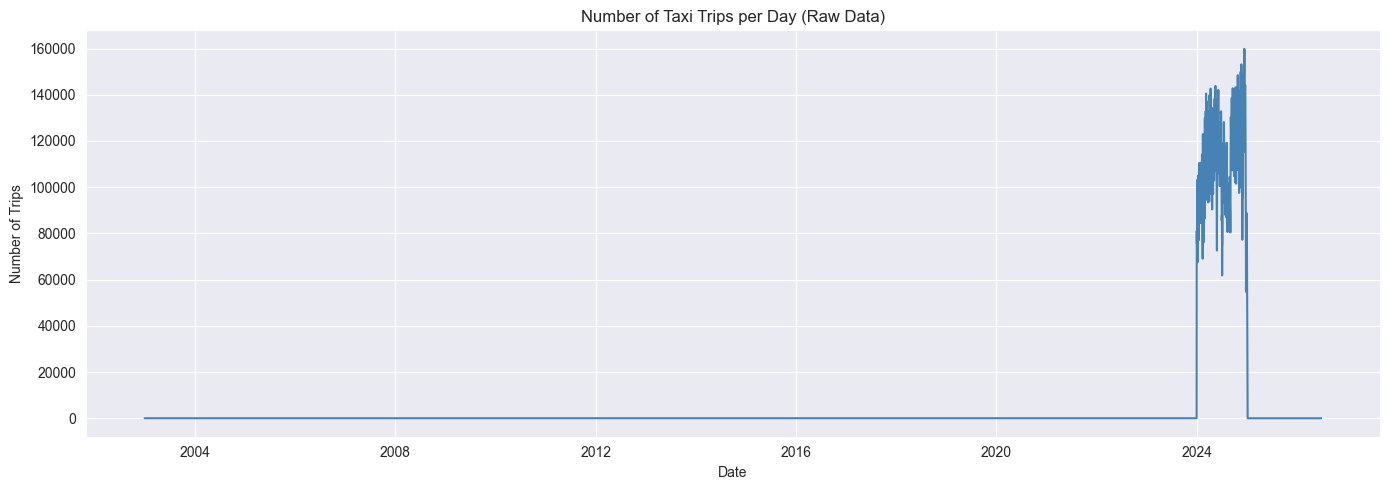

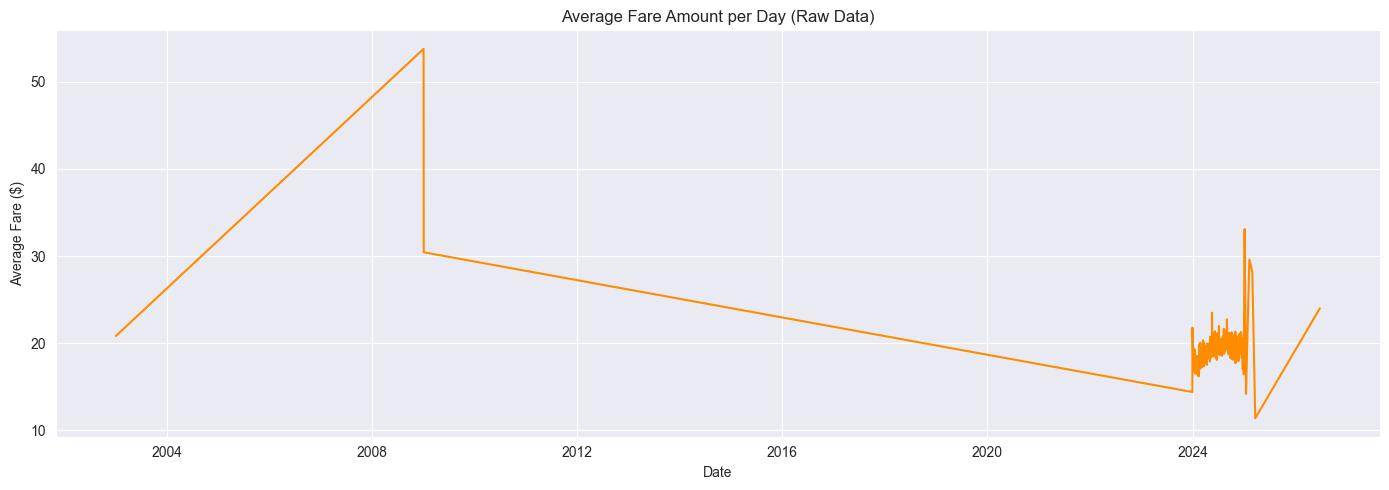

2002-12-31 16:46:07
2026-06-26 23:53:12
year
2002          11
2008          10
2009          18
2023          10
2024    41169664
2025           5
2026           2
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt

# --- Sumup Taxi-Data into one file ---
months = ["2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06", "2024-07", "2024-08", "2024-09", "2024-10", "2024-11", "2024-12"]
dfs = []

for month in months:
    path = f"data/yellow_tripdata_{month}.parquet"
    print(f"Loading {path} ...")
    df_month = pd.read_parquet(path)
    dfs.append(df_month)

df = pd.concat(dfs, ignore_index=True)

df["pickup_date"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.date

daily_counts = df.groupby("pickup_date").size()

plt.figure(figsize=(14, 5))
daily_counts.plot(kind="line", color="steelblue")
plt.title("Number of Taxi Trips per Day (Raw Data)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()


daily_avg_fare = df.groupby("pickup_date")["fare_amount"].mean()

plt.figure(figsize=(14, 5))
daily_avg_fare.plot(kind="line", color="darkorange")
plt.title("Average Fare Amount per Day (Raw Data)")
plt.xlabel("Date")
plt.ylabel("Average Fare ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(df["tpep_pickup_datetime"].min())
print(df["tpep_pickup_datetime"].max())

df["year"] = df["tpep_pickup_datetime"].dt.year
print(df["year"].value_counts().sort_index())

In [4]:
os.makedirs("data/processed", exist_ok=True)

# Weather data for Cologne
print("Load weather data from Meteostat ...")
location = Point(40.7128, -74.0060)  # NYC Koordinaten
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_data = Daily(location, start, end).fetch()
weather_data["date"] = weather_data.index.date  # Date as column for the merge

weather_data = weather_data.reset_index()[["date", "tavg", "tmin", "tmax", "prcp", "wspd"]]

months = [f"{i:02d}" for i in range(1, 13)]
cleaned_monthly_files = []

# Process each month individually
for month in months:
    file_path = f"data/yellow_tripdata_2024-{month}.parquet"
    output_path = f"data/processed/yellow_triuzpdata_2024-{month}_cleaned.parquet"

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"Process {file_path} ...")
    df = pd.read_parquet(file_path)

    # 2.1 Removing duplicates
    df.drop_duplicates(inplace=True)

    # 2.2 Handling missing values
    critical_cols = ["trip_distance", "passenger_count", "tpep_pickup_datetime", "tip_amount"]
    df.dropna(subset=critical_cols, inplace=True)

    # 2.3 Dropping irrelevant or redundant columns
    columns_to_drop = ["VendorID", "RatecodeID", "store_and_fwd_flag", "mta_tax", "improvement_surcharge"]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    # 3. Datetime conversion and time-based features
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["trip_duration_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
    df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek
    df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
    df["pickup_date"] = df["tpep_pickup_datetime"].dt.date

    # 4. Merging with weather data
    df = df.merge(weather_data, left_on="pickup_date", right_on="date", how="left")
    df.drop(columns=["date"], inplace=True)

    # 5. Feature engineering
    df["is_airport_trip"] = df["airport_fee"] > 0 if "airport_fee" in df.columns else False
    df["tip_per_mile"] = df["tip_amount"] / df["trip_distance"]
    df["tip_per_mile"] = df["tip_per_mile"].replace([float("inf"), -float("inf")], pd.NA)
    df["tip_ratio"] = df["tip_amount"] / df["fare_amount"]
    df["tip_ratio"] = df["tip_ratio"].replace([float("inf"), -float("inf")], pd.NA)

    # 6. Outlier filtering
    df = df[(df["trip_distance"] > 0.1) & (df["trip_distance"] < 50)]
    df = df[(df["fare_amount"] > 2) & (df["fare_amount"] < 200)]
    df = df[(df["tip_amount"] >= 0) & (df["tip_amount"] < 100)]

    # Saving
    df.to_parquet(output_path, index=False)
    cleaned_monthly_files.append(output_path)

    print(f"Saved: {output_path}")

print("Finished data preparation")

january_cleaned_df = pd.read_parquet("data/processed/yellow_tripdata_2024-01_cleaned.parquet")
display(january_cleaned_df.head())

Load weather data from Meteostat ...
Process data/yellow_tripdata_2024-01.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-01_cleaned.parquet
Process data/yellow_tripdata_2024-02.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-02_cleaned.parquet
Process data/yellow_tripdata_2024-03.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-03_cleaned.parquet
Process data/yellow_tripdata_2024-04.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-04_cleaned.parquet
Process data/yellow_tripdata_2024-05.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-05_cleaned.parquet
Process data/yellow_tripdata_2024-06.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-06_cleaned.parquet
Process data/yellow_tripdata_2024-07.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-07_cleaned.parquet
Process data/yellow_tripdata_2024-08.parquet ...
Saved: data/processed/yellow_triuzpdata_2024-08_cleaned.parquet
Process data/yellow_tripdata_2024-09.parquet ...
Saved: dat

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,...,pickup_month,pickup_date,tavg,tmin,tmax,prcp,wspd,is_airport_trip,tip_per_mile,tip_ratio
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,186,79,2,17.7,1.0,0.00,...,1,2024-01-01,8.3,7.2,9.1,14.9,21.2,False,0.000000,0.000000
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,140,236,1,10.0,3.5,3.75,...,1,2024-01-01,8.3,7.2,9.1,14.9,21.2,False,2.083333,0.375000
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,236,79,1,23.3,3.5,3.00,...,1,2024-01-01,8.3,7.2,9.1,14.9,21.2,False,0.638298,0.128755
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,79,211,1,10.0,3.5,2.00,...,1,2024-01-01,8.3,7.2,9.1,14.9,21.2,False,1.428571,0.200000
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,211,148,1,7.9,3.5,3.20,...,1,2024-01-01,8.3,7.2,9.1,14.9,21.2,False,4.000000,0.405063


In [5]:
# Check if data preparation worked

def check_data_quality_per_month(base_path="data/processed", year="2024"):
    months = [f"{i:02d}" for i in range(1, 13)]
    required_columns = [
        "tavg", "tmin", "tmax", "pickup_date", 
        "trip_distance", "passenger_count", 
        "tpep_pickup_datetime", "tip_amount", "fare_amount"
    ]
    
    for month in months:
        file_path = f"{base_path}/yellow_tripdata_{year}-{month}_cleaned.parquet"

        print(f"\n Check file: {file_path}")
        
        if not os.path.exists(file_path):
            print(f"File not found.")
            continue

        try:
            df = pd.read_parquet(file_path)
        except Exception as e:
            print(f"Error during import: {e}")
            continue

        print(f" Form: {df.shape}")

        # Check column
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            print(f"Missing columns: {missing_cols}")
            continue
        else:
            print("All expected columns available")

        # Check missing values
        null_counts = df[required_columns].isna().sum()
        if null_counts.sum() > 0:
            print("Missing values")
            print(null_counts[null_counts > 0])
        else:
            print("No missing values in critical columns")

        # Check values
        checks = {
            "trip_distance > 0": (df["trip_distance"] > 0).all(),
            "fare_amount > 0": (df["fare_amount"] > 0).all(),
            "tip_amount ≥ 0": (df["tip_amount"] >= 0).all(),
        }
        for desc, passed in checks.items():
            print(f"{'Passed' if passed else 'Not passed'} {desc}")
        
        print("Month completed")

check_data_quality_per_month()

# Weather data is sometimes missing for a few data records (i. e. individual trips) as no weather data was available for the exact time or location


 Check file: data/processed/yellow_tripdata_2024-01_cleaned.parquet
 Form: (2744840, 27)
All expected columns available
Missing values
tavg    14
tmin    14
tmax    14
dtype: int64
Passed trip_distance > 0
Passed fare_amount > 0
Passed tip_amount ≥ 0
Month completed

 Check file: data/processed/yellow_tripdata_2024-02_cleaned.parquet
 Form: (2743260, 27)
All expected columns available
Missing values
tavg    2
tmin    2
tmax    2
dtype: int64
Passed trip_distance > 0
Passed fare_amount > 0
Passed tip_amount ≥ 0
Month completed

 Check file: data/processed/yellow_tripdata_2024-03_cleaned.parquet
 Form: (3063127, 27)
All expected columns available
Missing values
tavg    2
tmin    2
tmax    2
dtype: int64
Passed trip_distance > 0
Passed fare_amount > 0
Passed tip_amount ≥ 0
Month completed

 Check file: data/processed/yellow_tripdata_2024-04_cleaned.parquet
 Form: (3014007, 27)
All expected columns available
Missing values
tavg    4
tmin    4
tmax    4
dtype: int64
Passed trip_distance > 

### Data Preparation: State Holidays



Load weather data from Meteostat ...
Loading data/yellow_tripdata_2024-01.parquet ...
Loading data/yellow_tripdata_2024-02.parquet ...
Loading data/yellow_tripdata_2024-03.parquet ...
Loading data/yellow_tripdata_2024-04.parquet ...
Loading data/yellow_tripdata_2024-05.parquet ...
Loading data/yellow_tripdata_2024-06.parquet ...
Loading data/yellow_tripdata_2024-07.parquet ...
Loading data/yellow_tripdata_2024-08.parquet ...
Loading data/yellow_tripdata_2024-09.parquet ...
Loading data/yellow_tripdata_2024-10.parquet ...
Loading data/yellow_tripdata_2024-11.parquet ...
Loading data/yellow_tripdata_2024-12.parquet ...


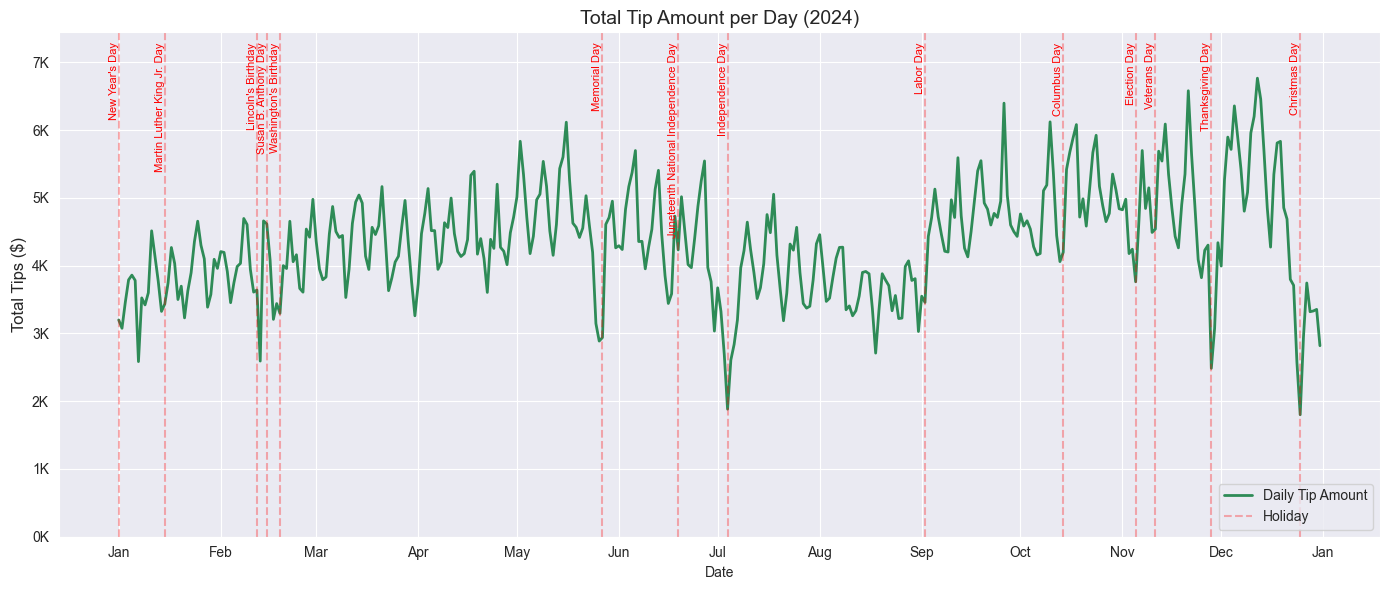

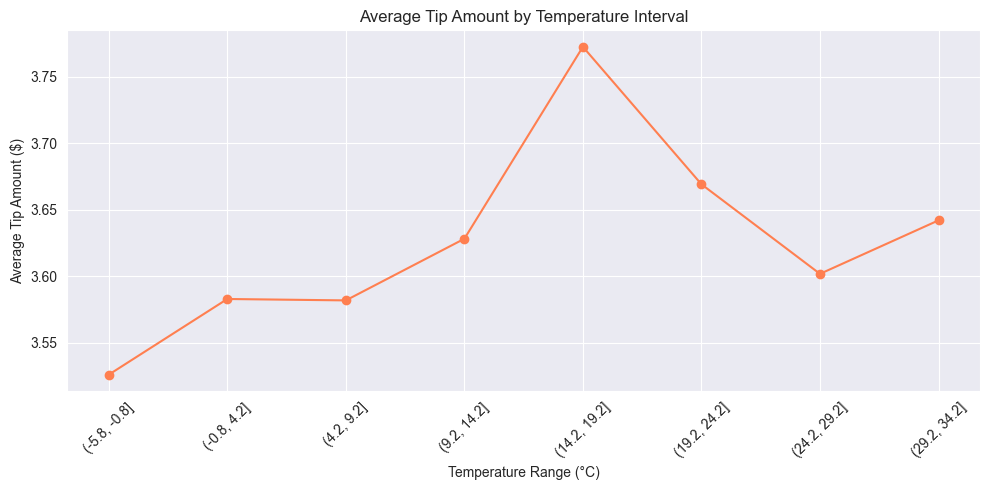

In [6]:
import numpy as np
import pandas as pd
import holidays as hd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
from meteostat import Point, Daily
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime

# --- Load Weather Data ---
print("Load weather data from Meteostat ...")
location = Point(40.7128, -74.0060)  # NYC Koordinaten
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_data = Daily(location, start, end).fetch()
weather_data["date"] = weather_data.index.date
weather_data = weather_data.reset_index()[["date", "tavg", "tmin", "tmax", "prcp", "wspd"]]

# --- Sumup Taxi Data of each month into one file ---
months = ["2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06", "2024-07", "2024-08", "2024-09", "2024-10", "2024-11", "2024-12"]
dfs = []

for month in months:
    path = f"data/yellow_tripdata_{month}.parquet"
    print(f"Loading {path} ...")
    df_month = pd.read_parquet(path)
    dfs.append(df_month)

df = pd.concat(dfs, ignore_index=True)

df = df.sample(n=500_000, random_state=42)

# --- Data Cleaning ---
df.drop_duplicates(inplace=True)

critical_cols = ["trip_distance", "passenger_count", "tpep_pickup_datetime", "tip_amount"]
df.dropna(subset=critical_cols, inplace=True)

columns_to_drop = ["VendorID", "RatecodeID", "store_and_fwd_flag", "mta_tax", "improvement_surcharge"]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

df = df[df["fare_amount"] > 0]
df = df[df["tip_amount"] >= 0]

df = df[df["fare_amount"] < 500]
df = df[df["tip_amount"] < 100]

df = df[df["trip_distance"] > 0]
df = df[df["tpep_dropoff_datetime"] > df["tpep_pickup_datetime"]]


df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

df["trip_duration_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
df['is_weekend'] = df['pickup_dayofweek'].isin([5, 6]).astype(int)

# --- Merge Weather Data ---
df = df.merge(weather_data, left_on="pickup_date", right_on="date", how="left")
df.drop(columns=["date"], inplace=True)

# --- Additional Features ---
if "airport_fee" in df.columns:
    df["is_airport_trip"] = df["airport_fee"] > 0
else:
    df["is_airport_trip"] = False

df["tip_per_mile"] = df.apply(lambda r: r["tip_amount"] / r["trip_distance"] if r["trip_distance"] > 0 else 0, axis=1)
df["tip_ratio"] = df.apply(lambda r: r["tip_amount"] / r["fare_amount"] if r["fare_amount"] > 0 else 0, axis=1)

# --- Cast Catagorical Data ---
df['PULocationID'] = df['PULocationID'].astype('category')
df['DOLocationID'] = df['DOLocationID'].astype('category')
df['is_airport_trip'] = df['is_airport_trip'].astype('category')
df['pickup_hour'] = df['pickup_hour'].astype('category')
df['pickup_dayofweek'] = df['pickup_dayofweek'].astype('category')
df['pickup_month'] = df['pickup_month'].astype('category')

# --- Holidays for NYC ---
ny_holidays = hd.US(state='NY', years=2024)
df["is_holiday"] = df["pickup_date"].isin(ny_holidays)
df["is_holiday"] = df["is_holiday"].astype('category')

# --- Define Time Window---
def time_of_day(hour):
    if 5 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif 17 <= hour <= 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['pickup_hour'].apply(time_of_day)
df['time_of_day'] = df['time_of_day'].astype('category')

# Averagespeed
df['avg_speed'] = df['trip_distance'] / df['trip_duration_minutes']
df['avg_speed'] = df['avg_speed'].replace([np.inf, -np.inf], 0)
df['avg_speed'] = df['avg_speed'].fillna(0)

# Rain yes/no
df['rain'] = (df['prcp'].fillna(0) > 0).astype(int)
df['rain'] = df['rain'].astype('category')

df['trip_distance'] = df['trip_distance'].clip(lower=0)
df['trip_duration_minutes'] = df['trip_duration_minutes'].clip(lower=0)

# Log-Transformation of trip_distance und trip_duration_minutes
df['log_trip_distance'] = np.log1p(df['trip_distance'])
df['log_trip_duration'] = np.log1p(df['trip_duration_minutes'])

# Fare–Tip Difference and Tip Ratio
df["fare_minus_tip"] = df["fare_amount"] - df["tip_amount"]
df["tip_ratio"] = df.apply(lambda r: r["tip_amount"] / r["fare_amount"] if r["fare_amount"] > 0 else 0, axis=1)

# Flag for Short Trip with High Tip
df["short_trip_high_tip"] = ((df["trip_distance"] < 1) & (df["tip_amount"] >= 5)).astype(int)

# Weathercondition
def weather_condition(row):
    prcp = row["prcp"] if pd.notna(row["prcp"]) else 0
    tmin = row["tmin"] if pd.notna(row["tmin"]) else 99

    if prcp > 0.5:
        return "heavy_rain"
    elif prcp > 0:
        return "rain"
    elif tmin <= 0 and prcp > 0:
        return "snow"
    else:
        return "clear"

df["weather_condition"] = df.apply(weather_condition, axis=1)
df["weather_condition"] = df["weather_condition"].astype("category")


#---Data Preparation: Holidays---#

df["pickup_date"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.date

df_2024 = df[df["pickup_date"].between(datetime(2024, 1, 1).date(), datetime(2024, 12, 31).date())]

daily_tips = df_2024.groupby("pickup_date")["tip_amount"].sum().reset_index()

ny_holidays = hd.US(state="NY", years=2024)
holiday_dates = [d for d in ny_holidays]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_tips["pickup_date"], daily_tips["tip_amount"], color="seagreen", linewidth=2, label="Daily Tip Amount")

y_max = daily_tips["tip_amount"].max()
y_upper = y_max * 1.1
ax.set_ylim(0, y_upper)

first = True
for holiday in holiday_dates:
    if daily_tips["pickup_date"].min() <= holiday <= daily_tips["pickup_date"].max():
        ax.axvline(holiday, color="red", linestyle="--", alpha=0.3,
                   label="Holiday" if first else None)
        name = ny_holidays.get(holiday)
        ax.text(holiday,
                y_upper * 0.98,
                name,
                rotation=90, fontsize=8, color="red",
                ha='right', va='top')
        first = False

ax.set_title("Total Tip Amount per Day (2024)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Total Tips ($)", fontsize=12)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/1000):,}K"))

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#---Data Preparation: Weather---#
df['temp_bin'] = pd.cut(df['tavg'], bins=np.arange(df['tavg'].min(), df['tavg'].max() + 5, 5))

avg_tip_temp = df.groupby('temp_bin', observed=True)['tip_amount'].mean()

plt.figure(figsize=(10, 5))
avg_tip_temp.plot(kind='line', marker='o', color='coral')
plt.title('Average Tip Amount by Temperature Interval')
plt.ylabel('Average Tip Amount ($)')
plt.xlabel('Temperature Range (°C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Modeling & 5. Evaluation

### Model 1: Linear Regression

In [7]:
# 1. Load Weather Data
print("Loading weather data from Meteostat ...")
location = Point(40.7128, -74.0060)  # NYC coordinates
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_data = Daily(location, start, end).fetch()
weather_data["date"] = weather_data.index.date
weather_data = weather_data.reset_index()[["date", "tavg", "tmin", "tmax", "prcp", "wspd"]]

# 2. Define Holidays
ny_holidays = hd.US(state='NY', years=2024)

# 3. Preprocess Function
def preprocess(df, weather_data, ny_holidays):
    df = df.drop_duplicates()
    df = df.dropna(subset=["trip_distance", "passenger_count", "tpep_pickup_datetime", "tip_amount"])

    columns_to_drop = ["VendorID", "RatecodeID", "store_and_fwd_flag", "mta_tax", "improvement_surcharge"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 500)]
    df = df[(df["tip_amount"] >= 0) & (df["tip_amount"] < 100)]
    df = df[(df["trip_distance"] > 0)]

    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df = df[df["tpep_dropoff_datetime"] > df["tpep_pickup_datetime"]]

    df["trip_duration_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
    df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek
    df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
    df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
    df['is_weekend'] = df['pickup_dayofweek'].isin([5, 6]).astype(int)

    df = df.merge(weather_data, left_on="pickup_date", right_on="date", how="left")
    df = df.drop(columns=["date"], errors='ignore')

    if "airport_fee" in df.columns:
        df["is_airport_trip"] = df["airport_fee"] > 0
    else:
        df["is_airport_trip"] = False

    df["tip_per_mile"] = df["tip_amount"] / df["trip_distance"]
    df["tip_per_mile"] = df["tip_per_mile"].replace([np.inf, -np.inf], 0).fillna(0)

    df["tip_ratio"] = df["tip_amount"] / df["fare_amount"]
    df["tip_ratio"] = df["tip_ratio"].replace([np.inf, -np.inf], 0).fillna(0)

    for col in ["PULocationID", "DOLocationID", "pickup_hour", "pickup_dayofweek", "pickup_month", "is_airport_trip"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    df["is_holiday"] = df["pickup_date"].isin(ny_holidays).astype(int)
    df["is_holiday"] = df["is_holiday"].astype("category")

    def time_of_day(hour):
        if 5 <= hour <= 11:
            return 'morning'
        elif 12 <= hour <= 16:
            return 'afternoon'
        elif 17 <= hour <= 21:
            return 'evening'
        else:
            return 'night'

    df["time_of_day"] = df["pickup_hour"].apply(lambda h: time_of_day(int(h)))
    df["time_of_day"] = df["time_of_day"].astype("category")

    df['avg_speed'] = df['trip_distance'] / df['trip_duration_minutes']
    df['avg_speed'] = df['avg_speed'].replace([np.inf, -np.inf], 0).fillna(0)

    df['rain'] = (df['prcp'].fillna(0) > 0).astype(int)

    df['log_trip_distance'] = np.log1p(df['trip_distance'].clip(lower=0))
    df['log_trip_duration'] = np.log1p(df['trip_duration_minutes'].clip(lower=0))

    df["fare_minus_tip"] = df["fare_amount"] - df["tip_amount"]
    df["short_trip_high_tip"] = ((df["trip_distance"] < 1) & (df["tip_amount"] >= 5)).astype(int)

    def weather_condition(row):
        prcp = row["prcp"] if pd.notna(row["prcp"]) else 0
        tmin = row["tmin"] if pd.notna(row["tmin"]) else 99

        if prcp > 0.5:
            return "heavy_rain"
        elif prcp > 0:
            return "rain"
        elif tmin <= 0 and prcp > 0:
            return "snow"
        else:
            return "clear"

    df["weather_condition"] = df.apply(weather_condition, axis=1)
    df["weather_condition"] = df["weather_condition"].astype("category")

    return df

# 4. Process All Months with Sampling
all_months = [f"2024-{month:02d}" for month in range(1, 13)]
processed_dfs = []

for month in all_months:
    print(f"Loading and processing {month} ...")
    path = f"data/yellow_tripdata_{month}.parquet"
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    df_month = pd.read_parquet(path)

    # Sample ~80,000 rows per month to stay memory-safe
    df_month = df_month.sample(n=80_000, random_state=42)
    df_month = preprocess(df_month, weather_data, ny_holidays)
    processed_dfs.append(df_month)

# 5. Combine All Processed Monthly Data
df_all = pd.concat(processed_dfs, ignore_index=True)
print(f"Final dataset shape: {df_all.shape}")

print(df_all.head(10))

Loading weather data from Meteostat ...
Loading and processing 2024-01 ...
Loading and processing 2024-02 ...
Loading and processing 2024-03 ...
Loading and processing 2024-04 ...
Loading and processing 2024-05 ...
Loading and processing 2024-06 ...
Loading and processing 2024-07 ...
Loading and processing 2024-08 ...
Loading and processing 2024-09 ...
Loading and processing 2024-10 ...
Loading and processing 2024-11 ...
Loading and processing 2024-12 ...
Final dataset shape: (840913, 37)
  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2024-01-20 13:31:30   2024-01-20 14:03:25              2.0          17.14   
1  2024-01-18 21:52:46   2024-01-18 22:03:21              1.0           2.49   
2  2024-01-01 03:43:58   2024-01-01 03:50:47              2.0           1.84   
3  2024-01-19 22:20:12   2024-01-19 22:50:12              1.0           3.60   
4  2024-01-06 22:41:50   2024-01-06 22:43:24              1.0           0.04   
5  2024-01-11 08:00:34   2

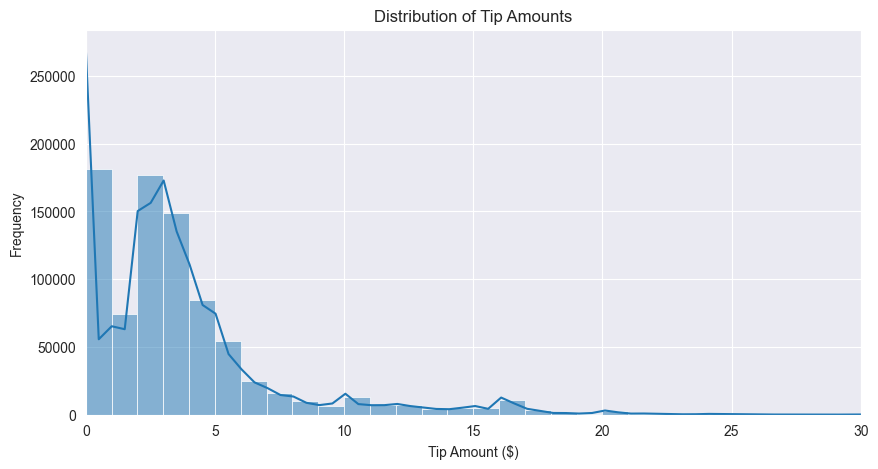

In [8]:
# Plot Tip Amount Distribution

plt.figure(figsize=(10, 5))
sns.histplot(df_all["tip_amount"], bins=100, kde=True)
plt.title("Distribution of Tip Amounts")
plt.xlabel("Tip Amount ($)")
plt.ylabel("Frequency")
plt.xlim(0, 30)
plt.grid(True)
plt.show()

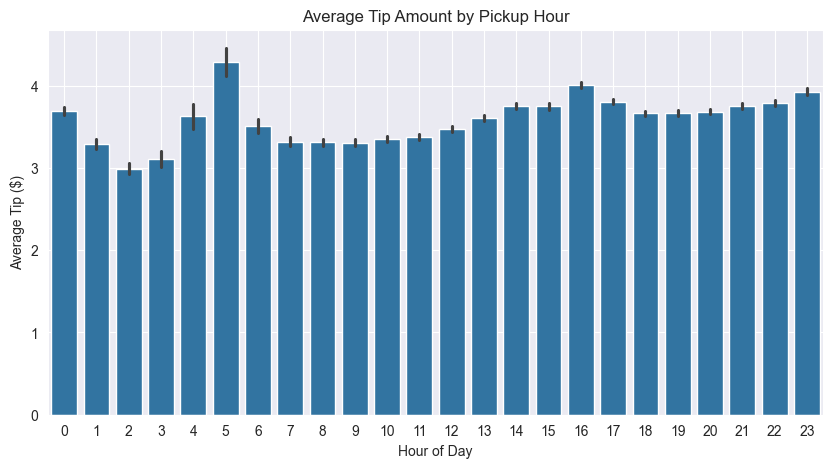

In [9]:
# Plot Average Tip per Hour of Day

plt.figure(figsize=(10, 5))
sns.barplot(x="pickup_hour", y="tip_amount", data=df_all, estimator=np.mean)
plt.title("Average Tip Amount by Pickup Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Tip ($)")
plt.grid(True)
plt.show()

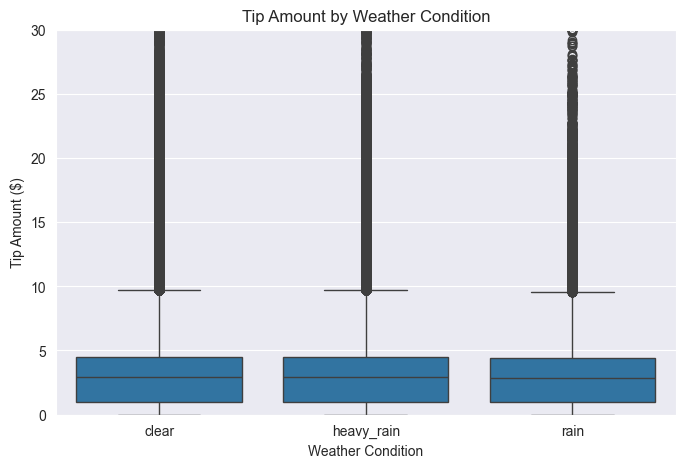

In [10]:
# Plot Tip Amount by Weather Condition

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_all, x="weather_condition", y="tip_amount")
plt.title("Tip Amount by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Tip Amount ($)")
plt.ylim(0, 30)
plt.grid(True)
plt.show()


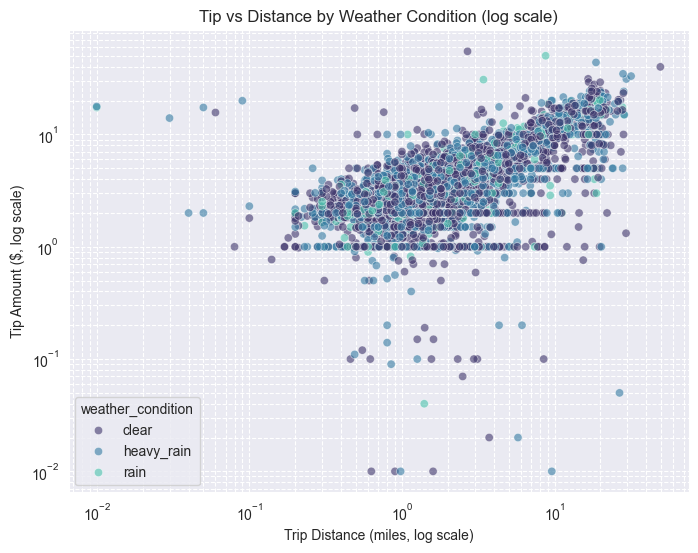

In [11]:
# Plot Tip Amount vs Trip Distance, colored by Weather

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all.sample(n=10000, random_state=42),
    x="trip_distance", y="tip_amount",
    hue="weather_condition", palette="mako", alpha=0.6
)
plt.xscale('log')
plt.yscale('log')
plt.title("Tip vs Distance by Weather Condition (log scale)")
plt.xlabel("Trip Distance (miles, log scale)")
plt.ylabel("Tip Amount ($, log scale)")
plt.grid(True, which="both", ls="--")
plt.show()

In [12]:
features = [
    "PULocationID", "DOLocationID",
    "pickup_hour", "pickup_dayofweek", "pickup_month",
    "is_airport_trip", "is_holiday", "is_weekend",
    "time_of_day", "avg_speed", "rain",
    "log_trip_distance", "log_trip_duration", "fare_amount",
    "tavg", "tmin", "tmax", "prcp", "wspd",
    "short_trip_high_tip",
    "weather_condition"
]

target = "tip_amount"

# Select feature data
X = df_all[features].copy()
y = df_all[target].copy()

# Fill missing values in numeric columns with zero
numeric_cols = X.select_dtypes(include=['number', 'Float64']).columns
X[numeric_cols] = X[numeric_cols].fillna(0)

# Identify categorical columns (already category dtype)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

# OneHotEncode categorical, leave numeric as is
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Build pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit model
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)

# Evaluate
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R^2: {r2_score(y_test, y_pred):.4f}")


MSE: 9.6443
MAE: 2.0236
R^2: 0.4034


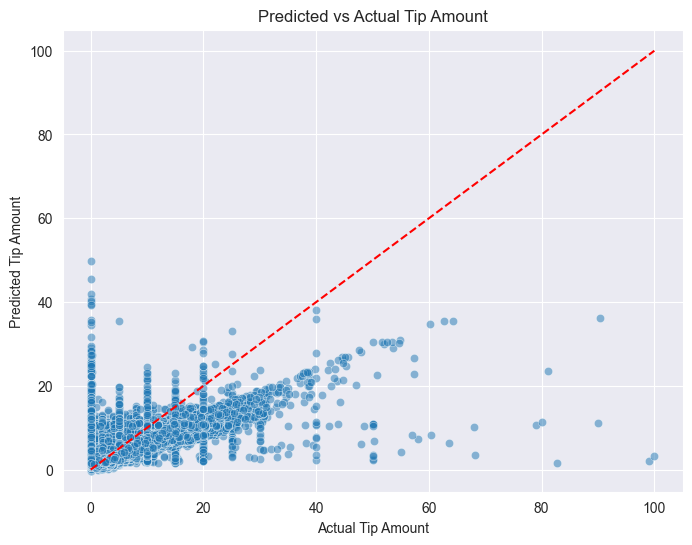

In [13]:
# Plot Predicted vs Actual

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Tip Amount")
plt.ylabel("Predicted Tip Amount")
plt.title("Predicted vs Actual Tip Amount")
plt.show()

Predicted vs Actual Tip Amount

- Observation: Predictions generally follow the correct trend, but there's a clear underestimation of larger tips.
- Problem: The model struggles with higher tip amounts, often predicting them too low.
- Implication: Linear regression cannot capture the nonlinear behavior of extreme values well.

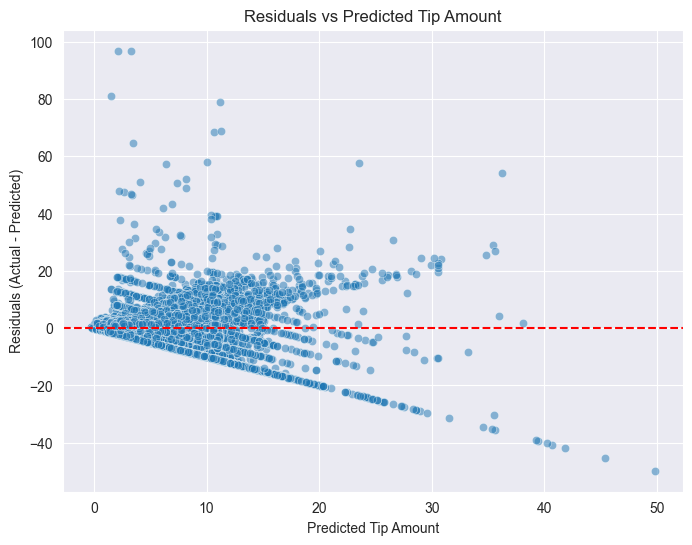

In [14]:
# Plot Residuals

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Tip Amount")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Tip Amount")
plt.show()

Residuals vs Predicted Tip Amount

- Observation: Residuals are not centered evenly around zero, there's a pattern.
    - At higher predicted tips, residuals skew negative, meaning the model underpredicts.
    - At low predicted tips, there's a mix, but also some large positive residuals.
- Implication: This indicates heteroscedasticity, variance in errors increases with tip amount. A sign that linear regression isn't ideal for this task.

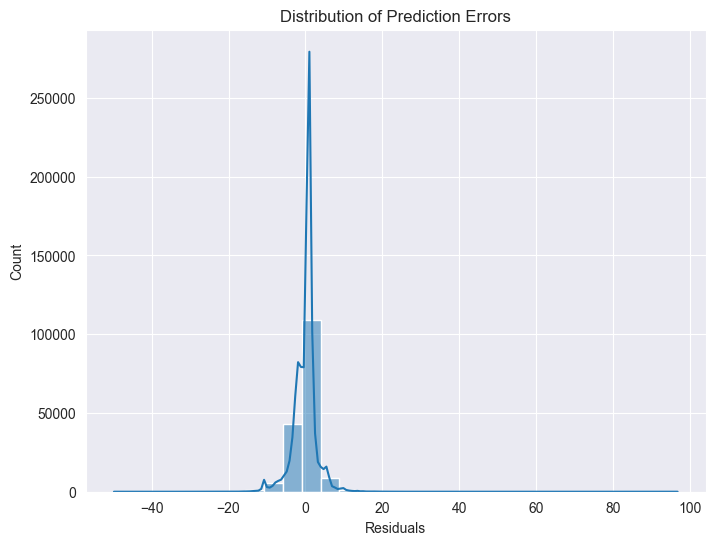

In [15]:
# Distribution of errors

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Prediction Errors")
plt.show()

Distribution of Residuals

- Observation: The residuals are somewhat centered around zero but show:
    - Skewness: More long tails on the positive side.
    - Kurtosis: Sharp central peak (possibly too sharp).
- Implication: While not terrible, this distribution again suggests a non-normal error structure, making linear regression assumptions questionable.

#### Summary

- Mean Squared Error (MSE): 9.6443
- Mean Absolute Error (MAE): 2.0236
- R^2 Score: 0.4034

For a Linear Regression baseline, this is decent given how noisy and variable tipping behavior can be. However, $2.02 MAE is a bit high in proportion to common tip amounts. An R² below 0.5 suggests many nonlinear or complex interactions aren't captured well. The performance can be improved by using a nonlinear model like LightGBM (our other model).

- Works moderately well for typical tip amounts.
- Underperforms for large tips (which are rare but important).
- Shows heteroscedasticity and non-normal residuals.

### Model 2: LightGBM

We used RandomizedSearchCV to tune the hyperparameters for both XGBoost and LightGBM, based on a random sample of 200,000 rows drawn from the entire 2024 dataset.
After identifying the best-performing parameter combinations for each algorithm, we trained and evaluated the final models on separate test data.

The results showed that LightGBM performed slightly better overall:
- LightGBM
    - MAE: 0.03599
    - RMSE: 0.2394
    - R²: 0.9964
- XGBoost
    - MAE: 0.04011
    - RMSE: 0.4219
    - R²: 0.9889


After evaluating both models, LightGBM showed slightly better performance, so we selected it for further optimization.

We then conducted a second RandomizedSearchCV specifically for LightGBM, using a larger sample of 500,000 rows and broader hyperparameter search space to further improve the model’s performance. The results can be seen below.

Load weather data from Meteostat ...
Loading data/yellow_tripdata_2024-01.parquet ...
Loading data/yellow_tripdata_2024-02.parquet ...
Loading data/yellow_tripdata_2024-03.parquet ...
Loading data/yellow_tripdata_2024-04.parquet ...
Loading data/yellow_tripdata_2024-05.parquet ...
Loading data/yellow_tripdata_2024-06.parquet ...
Loading data/yellow_tripdata_2024-07.parquet ...
Loading data/yellow_tripdata_2024-08.parquet ...
Loading data/yellow_tripdata_2024-09.parquet ...
Loading data/yellow_tripdata_2024-10.parquet ...
Loading data/yellow_tripdata_2024-11.parquet ...
Loading data/yellow_tripdata_2024-12.parquet ...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_d

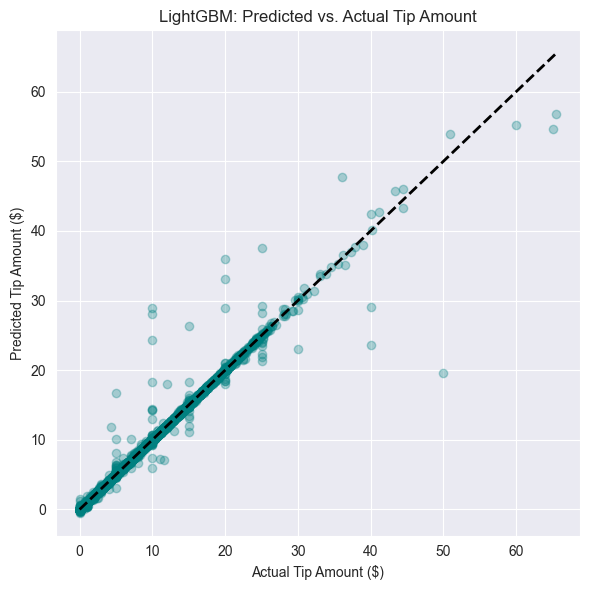

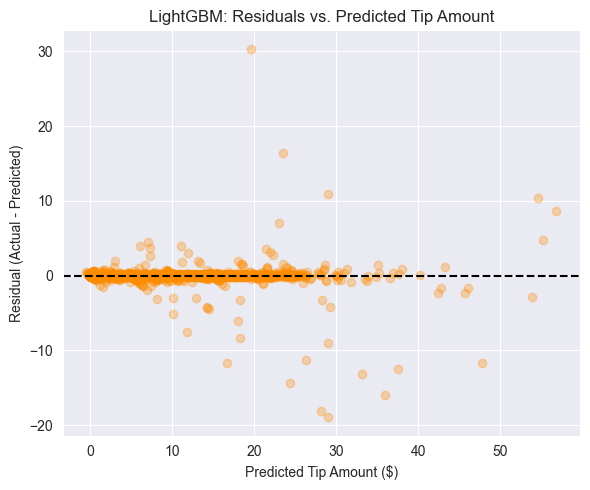

In [16]:
# 1. Load Weather Data
print("Load weather data from Meteostat ...")
location = Point(40.7128, -74.0060)
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_data = Daily(location, start, end).fetch()
weather_data["date"] = weather_data.index.date
weather_data = weather_data.reset_index()[["date", "tavg", "tmin", "tmax", "prcp", "wspd"]]

# 2. Load & merge several taxi months
months = ["2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06", "2024-07", "2024-08", "2024-09", "2024-10", "2024-11", "2024-12"]
dfs = []

for month in months:
    path = f"data/yellow_tripdata_{month}.parquet"
    print(f"Loading {path} ...")
    df_month = pd.read_parquet(path)
    dfs.append(df_month)

df = pd.concat(dfs, ignore_index=True)

# Drag Sample size
df = df.sample(n=500_000, random_state=42)

# 3. Data Cleaning
df.drop_duplicates(inplace=True)

critical_cols = ["trip_distance", "passenger_count", "tpep_pickup_datetime", "tip_amount"]
df.dropna(subset=critical_cols, inplace=True)

columns_to_drop = ["VendorID", "RatecodeID", "store_and_fwd_flag", "mta_tax", "improvement_surcharge"]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# 3b. Additional adjustment of outliers & incorrect values

# Only positive fares and tips
df = df[df["fare_amount"] > 0]
df = df[df["tip_amount"] >= 0]

# Remove unrealistically high values
df = df[df["fare_amount"] < 500]
df = df[df["tip_amount"] < 100]

# Avoid negative or 0-distances/duration
df = df[df["trip_distance"] > 0]
df = df[df["tpep_dropoff_datetime"] > df["tpep_pickup_datetime"]]

# 4. Data types & time features
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

df["trip_duration_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
df['is_weekend'] = df['pickup_dayofweek'].isin([5, 6]).astype(int)

# 5. Merge weather data
df = df.merge(weather_data, left_on="pickup_date", right_on="date", how="left")
df.drop(columns=["date"], inplace=True)

# 6. Additional features
if "airport_fee" in df.columns:
    df["is_airport_trip"] = df["airport_fee"] > 0
else:
    df["is_airport_trip"] = False

df["tip_per_mile"] = df.apply(lambda r: r["tip_amount"] / r["trip_distance"] if r["trip_distance"] > 0 else 0, axis=1)
df["tip_ratio"] = df.apply(lambda r: r["tip_amount"] / r["fare_amount"] if r["fare_amount"] > 0 else 0, axis=1)

# 7. Cast categorical vari
df['PULocationID'] = df['PULocationID'].astype('category')
df['DOLocationID'] = df['DOLocationID'].astype('category')
df['is_airport_trip'] = df['is_airport_trip'].astype('category')
df['pickup_hour'] = df['pickup_hour'].astype('category')
df['pickup_dayofweek'] = df['pickup_dayofweek'].astype('category')
df['pickup_month'] = df['pickup_month'].astype('category')

# 8. Holidays for NY
ny_holidays = hd.US(state='NY', years=2024)
df["is_holiday"] = df["pickup_date"].isin(ny_holidays)
df["is_holiday"] = df["is_holiday"].astype('category')

# Define time window
def time_of_day(hour):
    if 5 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif 17 <= hour <= 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['pickup_hour'].apply(time_of_day)
df['time_of_day'] = df['time_of_day'].astype('category')

# Calculate average speed
df['avg_speed'] = df['trip_distance'] / df['trip_duration_minutes']
df['avg_speed'] = df['avg_speed'].replace([np.inf, -np.inf], 0)
df['avg_speed'] = df['avg_speed'].fillna(0)

# Precipitation yes/no
df['rain'] = (df['prcp'].fillna(0) > 0).astype(int)
df['rain'] = df['rain'].astype('category')

df['trip_distance'] = df['trip_distance'].clip(lower=0)
df['trip_duration_minutes'] = df['trip_duration_minutes'].clip(lower=0)

# Log-Transformation of trip_distance and trip_duration_minutes
df['log_trip_distance'] = np.log1p(df['trip_distance'])
df['log_trip_duration'] = np.log1p(df['trip_duration_minutes'])

# Difference & ratio: fare_amount - tip_amount & tip_ratio
df["fare_minus_tip"] = df["fare_amount"] - df["tip_amount"]
df["tip_ratio"] = df.apply(lambda r: r["tip_amount"] / r["fare_amount"] if r["fare_amount"] > 0 else 0, axis=1)

# Flag for short trip with high tip
df["short_trip_high_tip"] = ((df["trip_distance"] < 1) & (df["tip_amount"] >= 5)).astype(int)

# Weather condition as a category
def weather_condition(row):
    prcp = row["prcp"] if pd.notna(row["prcp"]) else 0
    tmin = row["tmin"] if pd.notna(row["tmin"]) else 99

    if prcp > 0.5:
        return "heavy_rain"
    elif prcp > 0:
        return "rain"
    elif tmin <= 0 and prcp > 0:
        return "snow"
    else:
        return "clear"

df["weather_condition"] = df.apply(weather_condition, axis=1)
df["weather_condition"] = df["weather_condition"].astype("category")

# 9. Target & feature selection
target = "tip_amount"
features = [
    "PULocationID", "DOLocationID",
    "pickup_hour", "pickup_dayofweek", "pickup_month",
    "is_airport_trip", "is_holiday", "is_weekend",
    "time_of_day", "avg_speed", "rain",
    "log_trip_distance", "log_trip_duration", "fare_amount",
    "tavg", "tmin", "tmax", "prcp", "wspd", "fare_minus_tip", "tip_ratio",
    "short_trip_high_tip",
    "weather_condition"
]

X = df[features]
y = df[target]

# Categorical features for LightGBM
categorical_features = [
    "PULocationID", "DOLocationID",
    "pickup_hour", "pickup_dayofweek", "pickup_month",
    "is_airport_trip", "is_holiday", "is_weekend",
    "time_of_day", "rain", "weather_condition"
]

for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 10. Time-based split: train, validate, test
df['pickup_month_int'] = df['pickup_month'].astype(int)

# Make a split using the help column
train_df = df[df['pickup_month_int'] <= 9]
val_df   = df[df['pickup_month_int'].isin([10, 11])]
test_df  = df[df['pickup_month_int'] == 12]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

# 11. Train model

model = lgb.LGBMRegressor(
    num_leaves=50,
    n_estimators=2500,
    min_data_in_leaf=20,
    max_depth=15,
    learning_rate=0.05,
    feature_fraction=1.0,
    bagging_freq=5,
    bagging_fraction=1.0,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    categorical_feature=categorical_features
)

# 12. Evaluate model
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


#---Predicted vs Actual Tip Amount---#

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("LightGBM: Predicted vs. Actual Tip Amount")
plt.xlabel("Actual Tip Amount ($)")
plt.ylabel("Predicted Tip Amount ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


#---Residuals vs Predicted Tip Amount---#

residuals = y_test - y_pred

plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.3, color='darkorange')
plt.axhline(0, color='black', linestyle='--')
plt.title("LightGBM: Residuals vs. Predicted Tip Amount")
plt.xlabel("Predicted Tip Amount ($)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()